# Plots extension showcase

This example demonstrates all plotting helpers provided by the Fastback
Plots extension. It runs a small backtest to populate collectors, trades,
and cashflows, then renders each plot type for illustration.

In [1]:
using Fastback
using Dates
using Plots
using Statistics

---------------------------------------------------------
Simple backtest to generate plot data

In [2]:
acc = Account(; mode=AccountMode.Margin, base_currency=:USDT);
USDT = Cash(:USDT; digits=2);
deposit!(acc, USDT, 10_000.0);
perp = register_instrument!(acc, perpetual_instrument(
    Symbol("BTCUSDT-PERP"), :BTC, :USDT;
    margin_mode=MarginMode.PercentNotional,
    margin_init_long=0.10,
    margin_init_short=0.10,
    margin_maint_long=0.05,
    margin_maint_short=0.05,
))

collect_balance, balance_data = periodic_collector(Float64, Hour(1));
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_open, open_orders_data = periodic_collector(Int, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));
collect_gross, gross_exposure = periodic_collector(Float64, Hour(1));
collect_net, net_exposure = periodic_collector(Float64, Hour(1));
collect_long, long_exposure = periodic_collector(Float64, Hour(1));
collect_short, short_exposure = periodic_collector(Float64, Hour(1));

dt0 = DateTime(2020, 1, 1);
n_steps = 120;
prices = [100.0 + 0.05 * (i - 1) + 5.0 * sin(2pi * (i - 1) / 24) for i in 1:n_steps];

window = 24;
deadband = 0.002;
leverage_target = 2.0;

for i in 1:n_steps
    dt = dt0 + Hour(i - 1)
    last = prices[i]
    bid = last - 0.05
    ask = last + 0.05

    funding_rate = i % 8 == 0 ? (isodd(div(i, 8)) ? 0.0005 : -0.0005) : 0.0
    marks = [MarkUpdate(perp.index, bid, ask, last)]
    funding = funding_rate == 0.0 ? nothing : [FundingUpdate(perp.index, funding_rate)]
    process_step!(acc, dt; marks=marks, funding=funding, liquidate=true)

    if i >= window
        ma = mean(@view prices[i-window+1:i])
        signal = last > (1 + deadband) * ma ? 1.0 : (last < (1 - deadband) * ma ? -1.0 : 0.0)

        pos = get_position(acc, perp)
        target_qty = signal == 0.0 ? 0.0 : signal * leverage_target * equity(acc, :USDT) / last
        delta_qty = target_qty - pos.quantity

        if abs(delta_qty) > 1e-8
            order = Order(oid!(acc), perp, dt, last, delta_qty)
            fill_order!(acc, order; dt=dt, fill_price=last, bid=bid, ask=ask, last=last, commission_pct=0.0004)
        end
    end

    if should_collect(balance_data, dt)
        collect_balance(dt, cash_balance(acc, :USDT))
        eq = equity(acc, :USDT)
        collect_equity(dt, eq)
        collect_drawdown(dt, eq)
        pos = get_position(acc, perp)
        collect_open(dt, pos.quantity == 0.0 ? 0 : 1)
        notional = pos.quantity * last * perp.multiplier
        long_exp = max(notional, 0.0)
        short_exp = min(notional, 0.0)
        gross_exp = long_exp - short_exp
        collect_gross(dt, gross_exp)
        collect_net(dt, notional)
        collect_long(dt, long_exp)
        collect_short(dt, short_exp)
    end
end

pos = get_position(acc, perp)
if pos.quantity != 0.0
    dt = dt0 + Hour(n_steps - 1)
    last = prices[end]
    order = Order(oid!(acc), perp, dt, last, -pos.quantity)
    fill_order!(acc, order; dt=dt, fill_price=last, bid=last - 0.05, ask=last + 0.05, last=last, commission_pct=0.0004)
end

[Trade] date=2020-01-05 23:00:00 fill_px=104.66 USDT fill_qty=152.86 BTC remain_qty=0.00 BTC real_pnl_entry=-108.06 USDT real_pnl_settle=-0.00 USDT real_qty=-152.86 BTC commission=6.40 USDT cash_delta=-6.40 USDT pos_px=103.95 USDT pos_qty=-152.86 BTC reason=Normal

---------------------------------------------------------
Basic plot helpers

Balance plot

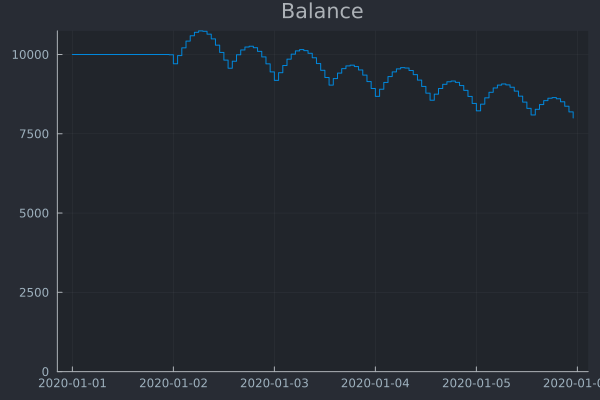

In [3]:
Fastback.plot_balance(balance_data)

Equity plot

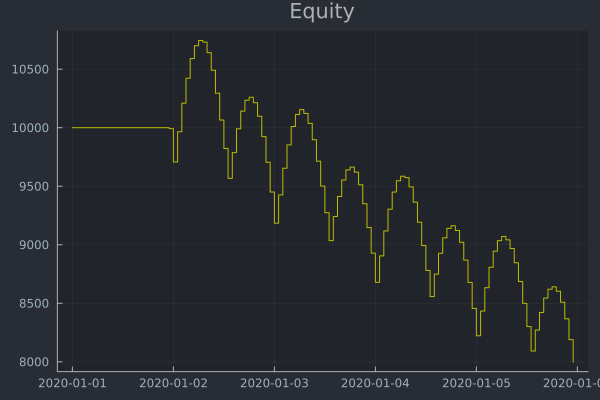

In [4]:
Fastback.plot_equity(equity_data)

Equity plot (sequence index)

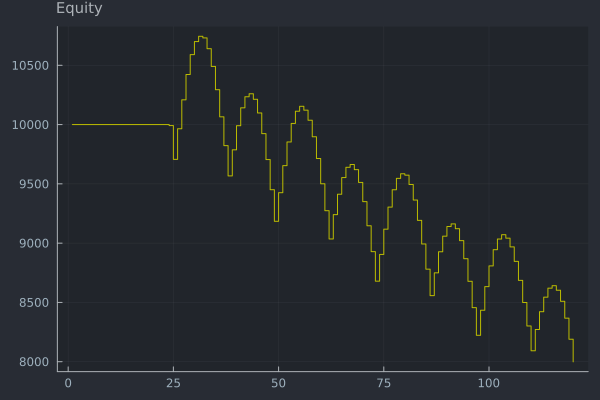

In [5]:
Fastback.plot_equity_seq(equity_data)

Open orders plot

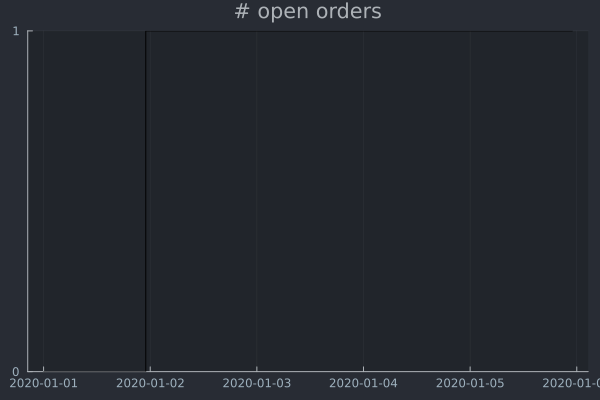

In [6]:
Fastback.plot_open_orders(open_orders_data)

Open orders plot (sequence index)

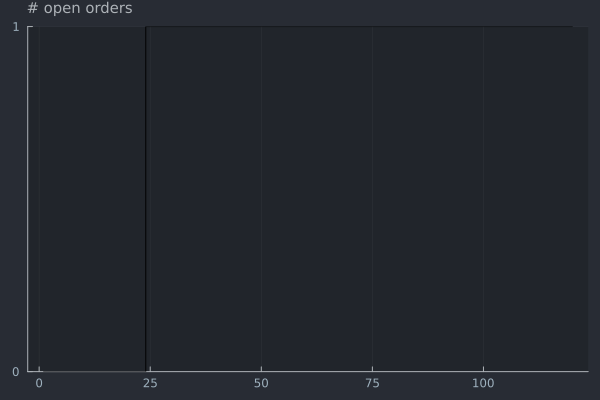

In [7]:
Fastback.plot_open_orders_seq(open_orders_data)

Drawdown plot

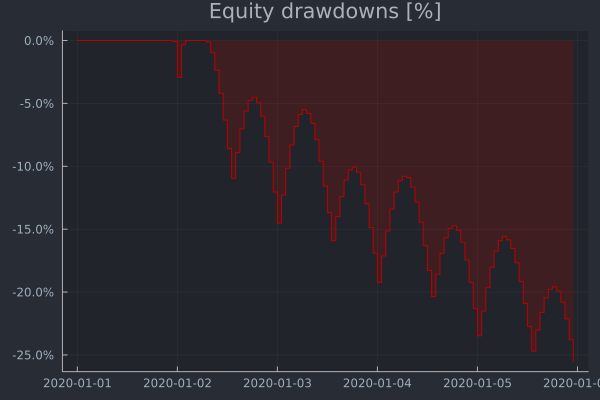

In [8]:
Fastback.plot_drawdown(drawdown_data)

Drawdown plot (sequence index)

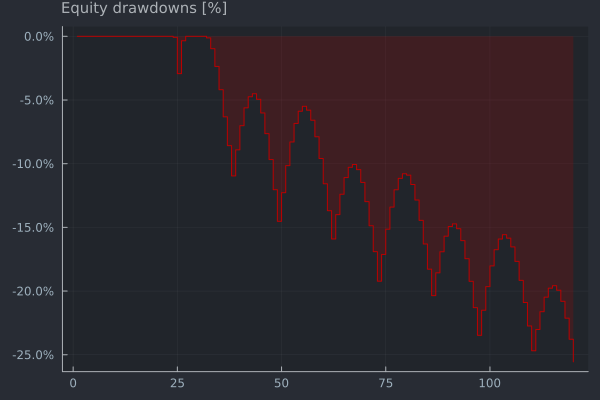

In [9]:
Fastback.plot_drawdown_seq(drawdown_data)

Exposure plot (gross, net, long, short)

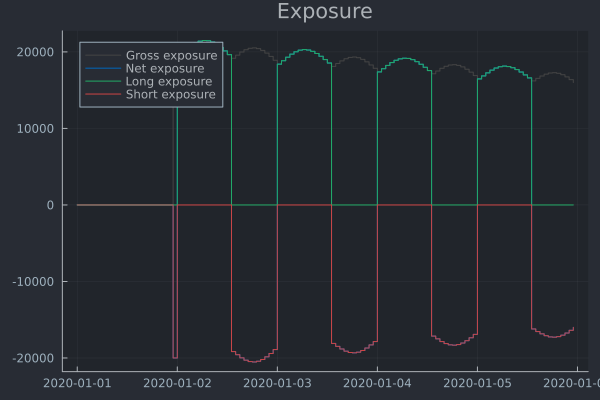

In [10]:
Fastback.plot_exposure(;
    gross=gross_exposure,
    net=net_exposure,
    long=long_exposure,
    short=short_exposure)

Equity + drawdown overlay

┌ Warning: Skipped yaxis arg right
└ @ Plots ~/.julia/packages/Plots/xC48f/src/axes.jl:75
┌ Warning: Skipped yaxis arg right
└ @ Plots ~/.julia/packages/Plots/xC48f/src/axes.jl:75


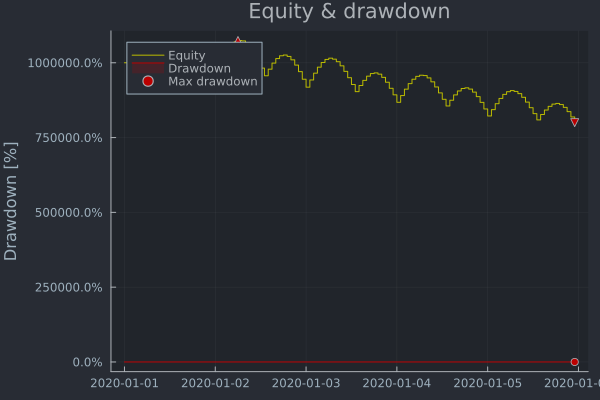

In [11]:
Fastback.plot_equity_drawdown(equity_data, drawdown_data)

---------------------------------------------------------
Overlay helpers (plot_! variants)

┌ Warning: Skipped yaxis arg right
└ @ Plots ~/.julia/packages/Plots/xC48f/src/axes.jl:75
┌ Warning: Skipped yaxis arg right
└ @ Plots ~/.julia/packages/Plots/xC48f/src/axes.jl:75


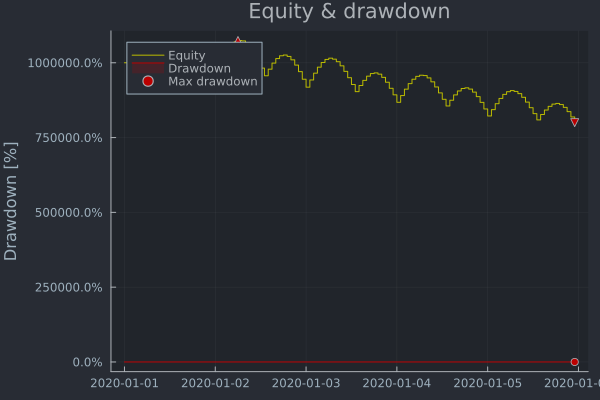

In [12]:
p = plot();
Fastback.plot_balance!(p, balance_data; title="Account");
Fastback.plot_equity!(p, equity_data);
p

p = plot();
Fastback.plot_equity_drawdown!(p, equity_data, drawdown_data; title="Equity & drawdown");
p

---------------------------------------------------------
Cashflow plots

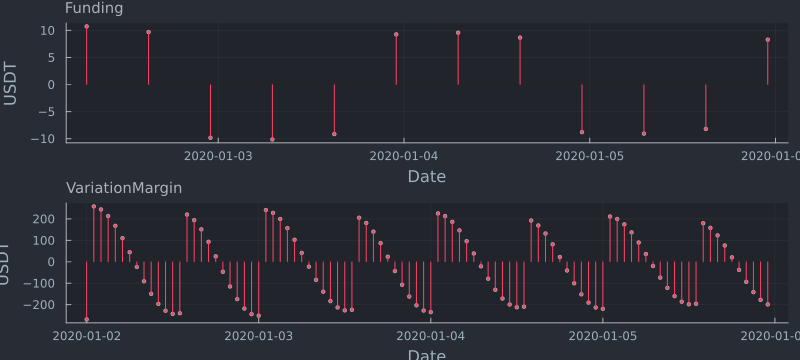

In [13]:
Fastback.plot_cashflows(acc)

---------------------------------------------------------
Return-based plots

Returns by day (violin)

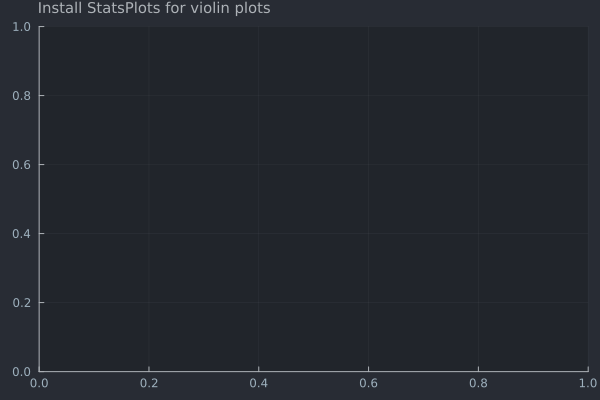

In [14]:
Fastback.plot_violin_realized_returns_by_day(acc.trades)

Returns by hour (violin)

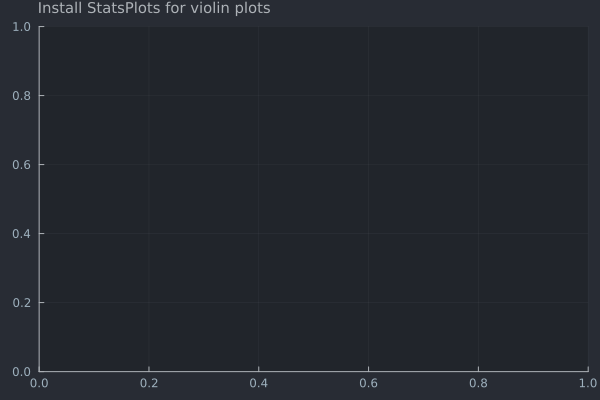

In [15]:
Fastback.plot_violin_realized_returns_by_hour(acc.trades)

Cumulative returns by hour

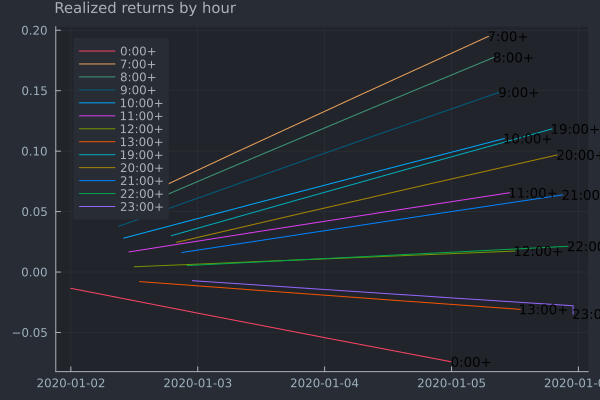

In [16]:
Fastback.plot_realized_cum_returns_by_hour(acc.trades)

Cumulative returns by hour (sequence index)

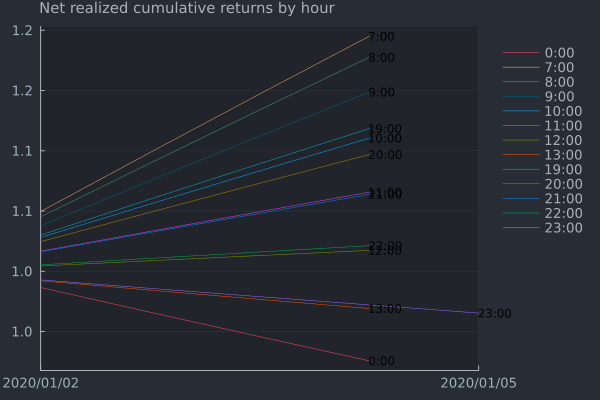

In [17]:
Fastback.plot_realized_cum_returns_by_hour_seq_net(acc.trades)

Cumulative returns by weekday

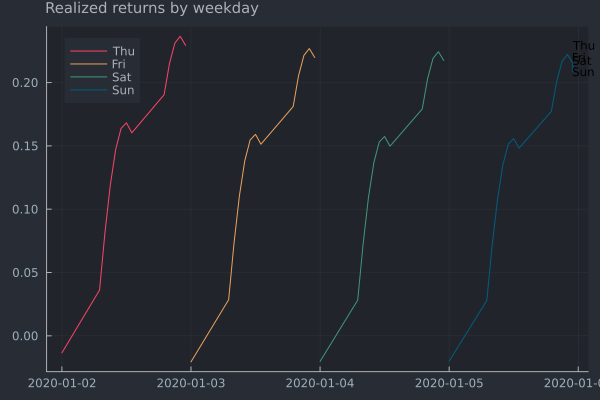

In [18]:
Fastback.plot_realized_cum_returns_by_weekday(acc.trades, t -> realized_return(t))

Cumulative returns by weekday (sequence index)

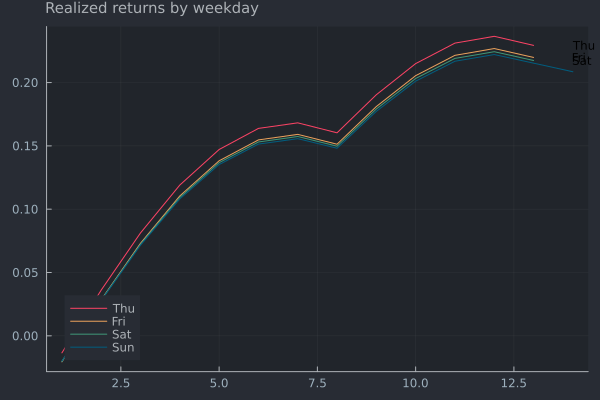

In [19]:
Fastback.plot_realized_cum_returns_by_weekday_seq(acc.trades, t -> realized_return(t))